<a href="https://colab.research.google.com/github/LatifulJoy/covid19-cnn-TL-mobilenet/blob/main/Brain_tumor_image_classification_using_Ensemble_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os 
import pathlib 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import random
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from google.colab import files
from sklearn.metrics import classification_report,confusion_matrix

In [2]:
files.upload()

Saving kaggle (2).json to kaggle (2).json


{'kaggle (2).json': b'{"username":"latifuljoy","key":"c9493e600d8dfc76ec7a58ea29031a33"}'}

In [3]:
import os
os.environ["KAGGLE_CONFIG_DIR"] = "/content"

In [5]:
!kaggle datasets download -d mohamedmetwalysherif/braintumordataset

 99% 118M/120M [00:05<00:00, 37.8MB/s] 
100% 120M/120M [00:05<00:00, 24.6MB/s]


In [6]:
!unzip \*.zip

Archive:  braintumordataset.zip
  inflating: Testing/glioma_tumor/IMG-0001-00001.jpg  
  inflating: Testing/glioma_tumor/IMG-0002-00001.jpg  
  inflating: Testing/glioma_tumor/IMG-0003-00001.jpg  
  inflating: Testing/glioma_tumor/IMG-0004-00001.jpg  
  inflating: Testing/glioma_tumor/IMG-0005-00001.jpg  
  inflating: Testing/glioma_tumor/IMG-0006-00001.jpg  
  inflating: Testing/glioma_tumor/IMG-0007-00001.jpg  
  inflating: Testing/glioma_tumor/IMG-0008-00001.jpg  
  inflating: Testing/glioma_tumor/IMG-0009-00001.jpg  
  inflating: Testing/glioma_tumor/IMG-0010-00001.jpg  
  inflating: Testing/glioma_tumor/IMG-0011-00001.jpg  
  inflating: Testing/glioma_tumor/IMG-0012-00001.jpg  
  inflating: Testing/glioma_tumor/IMG-0013-00001.jpg  
  inflating: Testing/glioma_tumor/IMG-0014-00001.jpg  
  inflating: Testing/glioma_tumor/IMG-0015-00001.jpg  
  inflating: Testing/glioma_tumor/IMG-0016-00001.jpg  
  inflating: Testing/glioma_tumor/IMG-0017-00001.jpg  
  inflating: Testing/glioma_tumor

In [7]:
for dirpath,dirnames,filenames in os.walk("/content/Training"):
    print(f"there are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

there are 4 directories and 0 images in '/content/Training'.
there are 0 directories and 981 images in '/content/Training/meningioma_tumor'.
there are 0 directories and 959 images in '/content/Training/pituitary_tumor'.
there are 0 directories and 445 images in '/content/Training/no_tumor'.
there are 0 directories and 891 images in '/content/Training/glioma_tumor'.


In [8]:
for dirpath,dirnames,filenames in os.walk("/content/Testing"):
    print(f"there are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

there are 4 directories and 0 images in '/content/Testing'.
there are 0 directories and 337 images in '/content/Testing/meningioma_tumor'.
there are 0 directories and 296 images in '/content/Testing/pituitary_tumor'.
there are 0 directories and 236 images in '/content/Testing/no_tumor'.
there are 0 directories and 147 images in '/content/Testing/glioma_tumor'.


In [9]:
import pathlib
import tensorflow as tf
train_dir = pathlib.Path("/content/Training")
class_names = np.array(sorted([item.name for item in train_dir.glob("*")]))
class_names

array(['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'],
      dtype='<U16')

In [10]:
import pathlib
import tensorflow as tf
validation_dir = pathlib.Path("/content/Testing")
class_names = np.array(sorted([item.name for item in train_dir.glob("*")]))
class_names

array(['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'],
      dtype='<U16')

In [11]:
img_height =224
img_width =224

In [14]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset = 'training',
    seed =123,
    image_size = (img_height, img_width),
    batch_size = 32
)

Found 3276 files belonging to 4 classes.
Using 2621 files for training.


In [15]:
validation_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset = 'validation',
    seed =123,
    image_size = (img_height, img_width),
    batch_size = 32
)

Found 3276 files belonging to 4 classes.
Using 655 files for validation.


In [16]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [17]:
import numpy as np
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x),y))
image_batch, label_batch= next(iter(normalized_ds))
first_image = image_batch[0]
#Notice the pixel values are now in (0,1)
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [18]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
validation_ds= validation_ds.cache().prefetch(buffer_size = AUTOTUNE)

# Developed CNN

In [23]:
import tensorflow as tf
opt=tf.keras.optimizers.Adam(learning_rate=0.0001)

In [24]:
model = Sequential()

#Block Number 1
model.add(Conv2D(input_shape = (224,224,3), filters=32,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(Conv2D(filters=32,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(MaxPool2D((2,2)))

#Block Number 2
model.add(Conv2D(filters=64,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))


model.add(Conv2D(filters=64,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(MaxPool2D((2,2)))
model.add(MaxPool2D((2,2)))


#Block Number 3
model.add(Conv2D(filters=128,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(Conv2D(filters=128,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(MaxPool2D((2,2)))

model.add(MaxPool2D((2,2)))


#Block Number 4
model.add(Conv2D(filters=256,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(Conv2D(filters=256,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(MaxPool2D((2,2)))

model.add(MaxPool2D((2,2)))

Dropout(0.40)


# Fully Connected layer
model.add(Flatten())

model.add(Dense(units=1024, activation="relu"))

model.add(Dense(units= 256, activation="relu"))
model.add(Dense(units=128, activation="relu"))
Dropout(0.40)

model.add(Dense(units=4, activation="softmax"))

In [25]:
model.compile(optimizer = opt, loss = tf.losses.SparseCategoricalCrossentropy(from_logits = False),metrics=['accuracy'])

In [26]:
history1 = model.fit(
    train_ds,
    validation_data = validation_ds,
    epochs=20
)

Epoch 1/20
82/82 [==============================] - 10s 119ms/step - loss: 1.1271 - accuracy: 0.5216 - val_loss: 1.1602 - val_accuracy: 0.5237
Epoch 2/20
82/82 [==============================] - 10s 118ms/step - loss: 0.8699 - accuracy: 0.6280 - val_loss: 0.7320 - val_accuracy: 0.6885
Epoch 3/20
82/82 [==============================] - 10s 120ms/step - loss: 0.6321 - accuracy: 0.7390 - val_loss: 0.7187 - val_accuracy: 0.6870
Epoch 4/20
82/82 [==============================] - 10s 119ms/step - loss: 0.5140 - accuracy: 0.7871 - val_loss: 0.5295 - val_accuracy: 0.8076
Epoch 5/20
82/82 [==============================] - 10s 119ms/step - loss: 0.3755 - accuracy: 0.8630 - val_loss: 0.4771 - val_accuracy: 0.8260
Epoch 6/20
82/82 [==============================] - 10s 118ms/step - loss: 0.3107 - accuracy: 0.8821 - val_loss: 0.3304 - val_accuracy: 0.9023
Epoch 7/20
82/82 [==============================] - 10s 117ms/step - loss: 0.1708 - accuracy: 0.9329 - val_loss: 0.3946 - val_accuracy: 0.8748

Text(0.5, 1.0, 'Accuracy Curves')

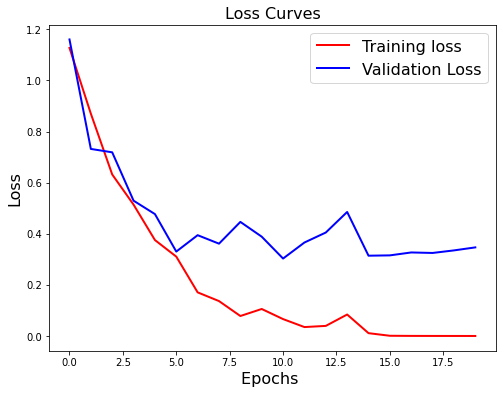

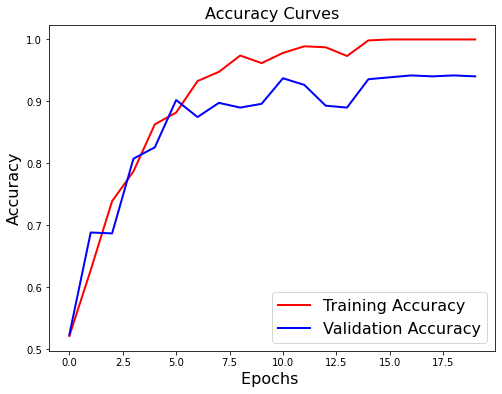

In [27]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history1.history['loss'],'r',linewidth=2.0)
plt.plot(history1.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=16)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history1.history['accuracy'],'r',linewidth=2.0)
plt.plot(history1.history['val_accuracy'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=16)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
model.save("/content/drive/MyDrive/model.hdf5")

# Transfer learning model Inception V3

In [30]:
import tensorflow as tf
opt=tf.keras.optimizers.Adam(learning_rate=0.0001)

In [31]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from keras.layers import GlobalAveragePooling2D, Flatten, BatchNormalization, Dense, Dropout
from tensorflow.keras.layers import MaxPooling2D,  GlobalAveragePooling2D
base_model = InceptionV3(
    input_shape=(224,224,3),
    weights="imagenet",
    include_top = False)

#Freeze the first ten layers
for layer in base_model.layers[:10]:
  layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x= Dense(512, activation = 'relu')(x)
x= Dropout(0.4)(x)
predictions  = Dense(4, activation = 'softmax')(x)
model1 = Model(inputs = base_model.inputs, outputs = predictions)

87924736/87910968 [==============================] - 0s 0us/step


In [32]:
model1.compile(optimizer =opt, loss = tf.losses.SparseCategoricalCrossentropy(from_logits = False),metrics=['accuracy'])

In [33]:
history1 = model1.fit(
    train_ds,
    validation_data = validation_ds,
    epochs=15
)

Epoch 1/15
82/82 [==============================] - 33s 290ms/step - loss: 0.6428 - accuracy: 0.7493 - val_loss: 1.3852 - val_accuracy: 0.4565
Epoch 2/15
82/82 [==============================] - 19s 233ms/step - loss: 0.1352 - accuracy: 0.9565 - val_loss: 0.3289 - val_accuracy: 0.8901
Epoch 3/15
82/82 [==============================] - 19s 232ms/step - loss: 0.0381 - accuracy: 0.9878 - val_loss: 0.2837 - val_accuracy: 0.9313
Epoch 4/15
82/82 [==============================] - 19s 229ms/step - loss: 0.0343 - accuracy: 0.9893 - val_loss: 0.2334 - val_accuracy: 0.9313
Epoch 5/15
82/82 [==============================] - 19s 229ms/step - loss: 0.0325 - accuracy: 0.9886 - val_loss: 0.3152 - val_accuracy: 0.9145
Epoch 6/15
82/82 [==============================] - 19s 230ms/step - loss: 0.0570 - accuracy: 0.9836 - val_loss: 0.3822 - val_accuracy: 0.9038
Epoch 7/15
82/82 [==============================] - 19s 231ms/step - loss: 0.0567 - accuracy: 0.9817 - val_loss: 0.2638 - val_accuracy: 0.9328

In [36]:
model1.save("/content/drive/MyDrive/model1.hdf5")

# DenseNet121

In [37]:
import tensorflow as tf
opt=tf.keras.optimizers.Adam(learning_rate=0.0001)

In [38]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from keras.layers import GlobalAveragePooling2D, Flatten, BatchNormalization, Dense, Dropout
from tensorflow.keras.layers import MaxPooling2D,  GlobalAveragePooling2D
base_model = DenseNet121(
    input_shape=(224,224,3),
    weights="imagenet",
    include_top = False)

#Freeze the first ten layers
for layer in base_model.layers[:10]:
  layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x= Dense(512, activation = 'relu')(x)
x= Dropout(0.4)(x)
predictions  = Dense(4, activation = 'softmax')(x)
model2 = Model(inputs = base_model.inputs, outputs = predictions)

29097984/29084464 [==============================] - 0s 0us/step


In [39]:
model2.compile(optimizer =opt, loss = tf.losses.SparseCategoricalCrossentropy(from_logits = False),metrics=['accuracy'])

In [40]:
history2 = model2.fit(
    train_ds,
    validation_data = validation_ds,
    epochs=15
)

Epoch 1/15
82/82 [==============================] - 51s 443ms/step - loss: 0.5666 - accuracy: 0.7806 - val_loss: 0.4801 - val_accuracy: 0.8122
Epoch 2/15
82/82 [==============================] - 29s 349ms/step - loss: 0.1251 - accuracy: 0.9611 - val_loss: 0.2507 - val_accuracy: 0.9130
Epoch 3/15
82/82 [==============================] - 29s 353ms/step - loss: 0.0281 - accuracy: 0.9958 - val_loss: 0.1596 - val_accuracy: 0.9557
Epoch 4/15
82/82 [==============================] - 29s 353ms/step - loss: 0.0102 - accuracy: 0.9985 - val_loss: 0.1693 - val_accuracy: 0.9511
Epoch 5/15
82/82 [==============================] - 29s 349ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.1644 - val_accuracy: 0.9573
Epoch 6/15
82/82 [==============================] - 29s 353ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.1577 - val_accuracy: 0.9542
Epoch 7/15
82/82 [==============================] - 29s 352ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.1570 - val_accuracy: 0.9588

In [42]:
model2.save("/content/drive/MyDrive/model2.hdf5")

# Ensemble Model

In [41]:
import tensorflow as tf
opt=tf.keras.optimizers.Adam(learning_rate=0.0001)

In [43]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average
model_1 = load_model("/content/drive/MyDrive/model.hdf5")
model_1 = Model(inputs=model_1.inputs,
                outputs=model_1.outputs,
                name='name_of_model_1')
model_2 = load_model('/content/drive/MyDrive/model1.hdf5')
model_2 = Model(inputs=model_2.inputs,
                outputs=model_2.outputs,
                name='name_of_model_2')

model_3 = load_model('/content/drive/MyDrive/model2.hdf5')
model_3 = Model(inputs=model_3.inputs,
                outputs=model_3.outputs,
                name='name_of_model_3')

models = [model_1, model_2, model_3]
model_input = Input(shape=(224, 224, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

In [44]:
ensemble_model.compile(optimizer = opt, 
                       loss= tf.losses.SparseCategoricalCrossentropy(from_logits=False),
                       metrics = ['accuracy'])

In [45]:
history = ensemble_model.fit(
    train_ds,
    validation_data = validation_ds,
    epochs =15
)

Epoch 1/15
82/82 [==============================] - 80s 740ms/step - loss: 0.0323 - accuracy: 0.9969 - val_loss: 0.3736 - val_accuracy: 0.9008
Epoch 2/15
82/82 [==============================] - 56s 677ms/step - loss: 0.0327 - accuracy: 0.9992 - val_loss: 0.2540 - val_accuracy: 0.9420
Epoch 3/15
82/82 [==============================] - 56s 677ms/step - loss: 0.0434 - accuracy: 0.9950 - val_loss: 0.2720 - val_accuracy: 0.9115
Epoch 4/15
82/82 [==============================] - 55s 671ms/step - loss: 0.0379 - accuracy: 0.9958 - val_loss: 0.1612 - val_accuracy: 0.9664
Epoch 5/15
82/82 [==============================] - 56s 677ms/step - loss: 0.0233 - accuracy: 0.9973 - val_loss: 0.1435 - val_accuracy: 0.9618
Epoch 6/15
82/82 [==============================] - 55s 672ms/step - loss: 0.0169 - accuracy: 0.9992 - val_loss: 0.1887 - val_accuracy: 0.9588
Epoch 7/15
82/82 [==============================] - 56s 677ms/step - loss: 0.0147 - accuracy: 1.0000 - val_loss: 0.1881 - val_accuracy: 0.9557